# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [1]:
# 필요한 라이브러리를 설치합니다.
# !pip install timm
# !pip install matplotlib
# !pip install seaborn
# !pip install optuna

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [2]:
import os
import time
import random
import copy

import optuna, math
import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler  # Mixed Precision용

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import wandb
from datetime import datetime

# 한글 폰트 설정 (시각화용)
plt.rcParams['font.family'] = ['DejaVu Sans']

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [4]:
# # Focal Loss 구현 (취약 클래스 4,7,14 집중 개선용)
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=None, gamma=2.0, num_classes=17):
#         super(FocalLoss, self).__init__()
#         if alpha is None:
#             alpha = torch.ones(num_classes)
#         else:
#             alpha = torch.tensor(alpha, dtype=torch.float32)
        
#         # 취약 클래스 강화
#         alpha[4] = 2.0
#         alpha[7] = 2.0  
#         alpha[14] = 2.0
        
#         # register_buffer로 디바이스 자동 관리
#         self.register_buffer('alpha', alpha)
#         self.gamma = gamma
        
#     def forward(self, inputs, targets):
#         ce_loss = F.cross_entropy(inputs, targets, reduction='none')
#         pt = torch.exp(-ce_loss)
#         alpha_t = self.alpha[targets]
#         focal_loss = alpha_t * (1 - pt) ** self.gamma * ce_loss
#         return focal_loss.mean()

In [5]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# 데이터셋 클래스를 정의합니다. (Hard Augmentation 포함)
class ImageDataset(Dataset):
    def __init__(self, data, path, epoch=0, total_epochs=10, is_train=True):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.epoch = epoch
        self.total_epochs = total_epochs
        self.is_train = is_train
        
        # Hard augmentation 확률 계산
        self.p_hard = 0.2 + 0.3 * (epoch / total_epochs) if is_train else 0
        
        # Normal augmentation
        self.normal_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
            ], p=0.6),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
            A.GaussNoise(var_limit=(30.0, 100.0), p=0.7),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
        
        # Hard augmentation
        self.hard_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
                A.Rotate(limit=[-15,15], p=1.0),
            ], p=0.8),
            A.OneOf([
                A.MotionBlur(blur_limit=15, p=1.0),
                A.GaussianBlur(blur_limit=15, p=1.0),
            ], p=0.95),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.9),
            A.GaussNoise(var_limit=(50.0, 150.0), p=0.8),
            A.JpegCompression(quality_lower=70, quality_upper=100, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert('RGB'))
        
        # 배치별 증강 선택
        if self.is_train and random.random() < self.p_hard:
            img = self.hard_aug(image=img)['image']
        else:
            img = self.normal_aug(image=img)['image']
        
        return img, target

In [6]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    scaler = GradScaler()  # Mixed Precision용
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)
        
        # Cutmix/Mixup 적용 (30% 확률)
        if random.random() < 0.3:
            mixed_x, y_a, y_b, lam = mixup_data(image, targets, alpha=1.0)
            with autocast(): preds = model(mixed_x)
            loss = lam * loss_fn(preds, y_a) + (1 - lam) * loss_fn(preds, y_b)
        else:
            with autocast(): preds = model(image)
            loss = loss_fn(preds, targets)

        model.zero_grad(set_to_none=True)

        scaler.scale(loss).backward()  # Mixed Precision용
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()  # Mixed Precision용

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [7]:
# validation을 위한 함수 추가
def validate_one_epoch(loader, model, loss_fn, device):
    """
    한 에폭 검증을 수행하는 함수
    - model.eval()로 모델을 평가 모드로 전환
    - torch.no_grad()로 gradient 계산 비활성화하여 메모리 절약
    - 검증 데이터에 대한 loss, accuracy, f1 score 계산
    """
    model.eval()  # 모델을 평가 모드로 전환 (dropout, batchnorm 비활성화)
    val_loss = 0
    preds_list = []
    targets_list = []
    
    with torch.no_grad():  # gradient 계산 비활성화로 메모리 절약
        pbar = tqdm(loader, desc="Validating")
        for image, targets in pbar:
            image = image.to(device)
            targets = targets.to(device)
            
            preds = model(image)  # 모델 예측
            loss = loss_fn(preds, targets)  # 손실 계산
            
            val_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())  # 예측 클래스 저장
            targets_list.extend(targets.detach().cpu().numpy())  # 실제 클래스 저장
            
            pbar.set_description(f"Val Loss: {loss.item():.4f}")
    
    val_loss /= len(loader)  # 평균 손실 계산
    val_acc = accuracy_score(targets_list, preds_list)  # 정확도 계산
    val_f1 = f1_score(targets_list, preds_list, average='macro')  # Macro F1 계산 (대회 평가지표)
    
    ret = {
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1,
    }
    
    return ret

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [8]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '../data/'

# model config
# model_name = 'tf_efficientnetv2_b3' # 'resnet50' 'efficientnet-b0', ...
# model_name = 'swin_base_patch4_window12_384_in22k'
model_name = 'convnext_base_384_in22ft1k'

# training config
img_size = 448
LR = 2e-4
EPOCHS = 50
BATCH_SIZE = 16
num_workers = 8
EMA = True  # Exponential Moving Average 사용 여부

In [9]:
# Optuna를 사용한 하이퍼파라미터 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    def objective(trial):
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
        
        # 간단한 3-fold CV로 빠른 평가
        skf_simple = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        fold_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf_simple.split(train_df, train_df['target'])):
            # 모델 생성
            model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
            optimizer = Adam(model.parameters(), lr=lr)
            loss_fn = nn.CrossEntropyLoss()
            
            # 간단한 2 epoch 학습
            for epoch in range(2):
                train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
            
            val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
            fold_scores.append(val_ret['val_f1'])
        
        return np.mean(fold_scores)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    
    # 최적 파라미터 적용
    LR = study.best_params['lr']
    BATCH_SIZE = study.best_params['batch_size']
    print(f"Best params: {study.best_params}")

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [10]:
# Optuna 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    # 위의 objective 함수와 study 코드
    pass

# K-Fold 적용

In [11]:
# K-Fold 설정
N_FOLDS = 5  # 5-fold로 설정 (데이터가 적으므로)
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# 클래스별 최소 샘플 보장 확인
# for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
#     assert len(np.unique(train_df.iloc[val_idx]['target'])) == 17

# 전체 학습 데이터 로드
train_df = pd.read_csv("../data/train.csv")

# K-Fold 결과를 저장할 리스트
fold_results = []
fold_models = []  # 각 fold의 최고 성능 모델을 저장
fold_class_accuracies = [] # 각 fold의 클래스별 정확도 저장

print(f"Starting {N_FOLDS}-Fold Cross Validation...")

# LR = best_params['lr']
# BATCH_SIZE = best_params['batch_size']

# K-Fold Cross Validation 시작
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    print(f"\n{'='*50}")
    print(f"FOLD {fold + 1}/{N_FOLDS}")
    print(f"{'='*50}")
    
    current_model = model_name
    
    # 현재 fold의 train/validation 데이터 분할
    train_fold_df = train_df.iloc[train_idx].reset_index(drop=True)
    val_fold_df = train_df.iloc[val_idx].reset_index(drop=True)
    
    # 현재 fold의 Dataset 생성
    trn_dataset = ImageDataset(
        train_fold_df,
        "../data/train/",
        # transform=trn_transform
        epoch=0,  # 현재 epoch 전달
        total_epochs=EPOCHS,
        is_train=True
    )
    
    val_dataset = ImageDataset(
        val_fold_df,
        "../data/train/",
        # transform=tst_transform  # 검증에는 증강 적용 안함
        epoch=0,  # validation은 epoch 관계없음
        total_epochs=EPOCHS,
        is_train=False  # validation이므로 hard augmentation 비활성화
    )
    
    # 현재 fold의 DataLoader 생성
    trn_loader = DataLoader(
        trn_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    print(f"Train samples: {len(trn_dataset)}, Validation samples: {len(val_dataset)}")
    
    # 모델 초기화 (각 fold마다 새로운 모델)
    model = timm.create_model(
        current_model,
        pretrained=True,
        num_classes=17
    ).to(device)
    
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.02)  # Label Smoothing 적용
    optimizer = Adam(model.parameters(), lr=LR)
    
    # Learning Rate Scheduler 추가
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
    
    # 현재 fold의 최고 성능 추적
    best_val_f1 = 0.0
    best_model = None
    
    # 현재 fold 학습
    for epoch in range(EPOCHS):
        # Training
        train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
        
        # Validation
        val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
        
        # Scheduler step 추가
        scheduler.step()
        
        print(f"Epoch {epoch+1:2d} | "
              f"Train Loss: {train_ret['train_loss']:.4f} | "
              f"Train F1: {train_ret['train_f1']:.4f} | "
              f"Val Loss: {val_ret['val_loss']:.4f} | "
              f"Val F1: {val_ret['val_f1']:.4f}")
        
        # 최고 성능 모델 저장
        if val_ret['val_f1'] > best_val_f1:
            best_val_f1 = val_ret['val_f1']
            best_model = copy.deepcopy(model.state_dict())
            
            # Best 모델 분석
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for image, targets in val_loader:
                    preds = model(image.to(device)).argmax(dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_targets.extend(targets.numpy())
            
            # 클래스별 정확도
            fold_class_acc = {}
            for c in range(17):
                mask = np.array(val_targets) == c
                if mask.sum() > 0:
                    fold_class_acc[c] = (np.array(val_preds)[mask] == c).mean()
    
    # 현재 fold 결과 저장
    fold_results.append({
        'fold': fold + 1,
        'best_val_f1': best_val_f1,
        'train_samples': len(trn_dataset),
        'val_samples': len(val_dataset)
    })
    
    fold_models.append(best_model)
    
    print(f"Fold {fold + 1} Best Validation F1: {best_val_f1:.4f}")
    
    fold_class_accuracies.append(fold_class_acc) # 각 fold의 클래스별 정확도 저장

# K-Fold 결과 요약
print(f"\n{'='*60}")
print("K-FOLD CROSS VALIDATION RESULTS")
print(f"{'='*60}")

val_f1_scores = [result['best_val_f1'] for result in fold_results]
mean_f1 = np.mean(val_f1_scores)
std_f1 = np.std(val_f1_scores)

for result in fold_results:
    print(f"Fold {result['fold']}: {result['best_val_f1']:.4f}")

print(f"\nMean CV F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Best single fold: {max(val_f1_scores):.4f}")

Starting 5-Fold Cross Validation...

FOLD 1/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.8386: 100%|██████████| 20/20 [00:05<00:00,  3.39it/s]

Epoch  1 | Train Loss: 1.7551 | Train F1: 0.4232 | Val Loss: 0.7770 | Val F1: 0.6683



Val Loss: 0.7394: 100%|██████████| 20/20 [00:04<00:00,  4.66it/s]

Epoch  2 | Train Loss: 0.8955 | Train F1: 0.6752 | Val Loss: 0.5233 | Val F1: 0.8408



Val Loss: 0.5757: 100%|██████████| 20/20 [00:04<00:00,  4.74it/s]


Epoch  3 | Train Loss: 0.7707 | Train F1: 0.7264 | Val Loss: 0.4470 | Val F1: 0.8605


Val Loss: 0.5702: 100%|██████████| 20/20 [00:04<00:00,  4.54it/s]


Epoch  4 | Train Loss: 0.7765 | Train F1: 0.7172 | Val Loss: 0.5392 | Val F1: 0.8302


Val Loss: 0.4599: 100%|██████████| 20/20 [00:04<00:00,  4.58it/s]

Epoch  5 | Train Loss: 0.6041 | Train F1: 0.7657 | Val Loss: 0.3896 | Val F1: 0.8985



Val Loss: 0.3807: 100%|██████████| 20/20 [00:04<00:00,  4.54it/s]


Epoch  6 | Train Loss: 0.6849 | Train F1: 0.7962 | Val Loss: 0.3599 | Val F1: 0.8911


Val Loss: 0.3956: 100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


Epoch  7 | Train Loss: 0.6259 | Train F1: 0.7621 | Val Loss: 0.3374 | Val F1: 0.9163


Val Loss: 0.4189: 100%|██████████| 20/20 [00:04<00:00,  4.74it/s]


Epoch  8 | Train Loss: 0.6081 | Train F1: 0.7732 | Val Loss: 0.3399 | Val F1: 0.9245


Val Loss: 0.4556: 100%|██████████| 20/20 [00:04<00:00,  4.52it/s]


Epoch  9 | Train Loss: 0.5471 | Train F1: 0.7628 | Val Loss: 0.3421 | Val F1: 0.9423


Val Loss: 0.5189: 100%|██████████| 20/20 [00:04<00:00,  4.70it/s]


Epoch 10 | Train Loss: 0.4649 | Train F1: 0.8424 | Val Loss: 0.3341 | Val F1: 0.9261


Val Loss: 0.4306: 100%|██████████| 20/20 [00:04<00:00,  4.85it/s]


Epoch 11 | Train Loss: 0.4339 | Train F1: 0.8472 | Val Loss: 0.3142 | Val F1: 0.9410


Val Loss: 0.5155: 100%|██████████| 20/20 [00:04<00:00,  4.58it/s]


Epoch 12 | Train Loss: 0.4643 | Train F1: 0.8522 | Val Loss: 0.3189 | Val F1: 0.9503


Val Loss: 0.3896: 100%|██████████| 20/20 [00:04<00:00,  4.70it/s]


Epoch 13 | Train Loss: 0.4583 | Train F1: 0.8476 | Val Loss: 0.3153 | Val F1: 0.9420


Val Loss: 0.5375: 100%|██████████| 20/20 [00:04<00:00,  4.69it/s]


Epoch 14 | Train Loss: 0.4907 | Train F1: 0.8158 | Val Loss: 0.3614 | Val F1: 0.9261


Val Loss: 0.7522: 100%|██████████| 20/20 [00:04<00:00,  4.38it/s]


Epoch 15 | Train Loss: 0.5317 | Train F1: 0.8141 | Val Loss: 0.3908 | Val F1: 0.9039


Val Loss: 0.3105: 100%|██████████| 20/20 [00:04<00:00,  4.60it/s]


Epoch 16 | Train Loss: 0.4277 | Train F1: 0.8329 | Val Loss: 0.2973 | Val F1: 0.9543


Val Loss: 0.6416: 100%|██████████| 20/20 [00:04<00:00,  4.50it/s]


Epoch 17 | Train Loss: 0.4122 | Train F1: 0.8843 | Val Loss: 0.2930 | Val F1: 0.9659


Val Loss: 0.2425: 100%|██████████| 20/20 [00:04<00:00,  4.52it/s]


Epoch 18 | Train Loss: 0.4804 | Train F1: 0.7643 | Val Loss: 0.3122 | Val F1: 0.9598


Val Loss: 0.4142: 100%|██████████| 20/20 [00:04<00:00,  4.50it/s]


Epoch 19 | Train Loss: 0.4070 | Train F1: 0.8886 | Val Loss: 0.3436 | Val F1: 0.9303


Val Loss: 0.2198: 100%|██████████| 20/20 [00:04<00:00,  4.68it/s]


Epoch 20 | Train Loss: 0.3734 | Train F1: 0.8701 | Val Loss: 0.3056 | Val F1: 0.9458


Val Loss: 0.8786: 100%|██████████| 20/20 [00:04<00:00,  4.54it/s]


Epoch 21 | Train Loss: 0.4224 | Train F1: 0.8532 | Val Loss: 0.3290 | Val F1: 0.9479


Val Loss: 0.7352: 100%|██████████| 20/20 [00:04<00:00,  4.71it/s]


Epoch 22 | Train Loss: 0.3939 | Train F1: 0.8595 | Val Loss: 0.3097 | Val F1: 0.9548


Val Loss: 0.4291: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


Epoch 23 | Train Loss: 0.4501 | Train F1: 0.8099 | Val Loss: 0.2919 | Val F1: 0.9520


Val Loss: 0.2875: 100%|██████████| 20/20 [00:04<00:00,  4.65it/s]


Epoch 24 | Train Loss: 0.4141 | Train F1: 0.8305 | Val Loss: 0.3013 | Val F1: 0.9555


Val Loss: 0.3765: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


Epoch 25 | Train Loss: 0.4051 | Train F1: 0.8661 | Val Loss: 0.2859 | Val F1: 0.9462


Val Loss: 0.6437: 100%|██████████| 20/20 [00:04<00:00,  4.37it/s]

Epoch 26 | Train Loss: 0.3663 | Train F1: 0.9003 | Val Loss: 0.2790 | Val F1: 0.9690



Val Loss: 0.8098: 100%|██████████| 20/20 [00:04<00:00,  4.49it/s]


Epoch 27 | Train Loss: 0.3786 | Train F1: 0.9025 | Val Loss: 0.3767 | Val F1: 0.9394


Val Loss: 1.0080: 100%|██████████| 20/20 [00:04<00:00,  4.62it/s]


Epoch 28 | Train Loss: 0.3859 | Train F1: 0.8511 | Val Loss: 0.3201 | Val F1: 0.9562


Val Loss: 0.8151: 100%|██████████| 20/20 [00:04<00:00,  4.66it/s]


Epoch 29 | Train Loss: 0.3726 | Train F1: 0.8400 | Val Loss: 0.2820 | Val F1: 0.9637


Val Loss: 0.5567: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


Epoch 30 | Train Loss: 0.3058 | Train F1: 0.8711 | Val Loss: 0.3079 | Val F1: 0.9574


Val Loss: 0.3975: 100%|██████████| 20/20 [00:04<00:00,  4.66it/s]


Epoch 31 | Train Loss: 0.4239 | Train F1: 0.8683 | Val Loss: 0.2934 | Val F1: 0.9612


Val Loss: 0.8044: 100%|██████████| 20/20 [00:04<00:00,  4.59it/s]


Epoch 32 | Train Loss: 0.3636 | Train F1: 0.8856 | Val Loss: 0.3446 | Val F1: 0.9520


Val Loss: 0.3871: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s]


Epoch 33 | Train Loss: 0.4325 | Train F1: 0.8138 | Val Loss: 0.3010 | Val F1: 0.9590


Val Loss: 0.1923: 100%|██████████| 20/20 [00:04<00:00,  4.79it/s]


Epoch 34 | Train Loss: 0.3247 | Train F1: 0.8897 | Val Loss: 0.2666 | Val F1: 0.9603


Val Loss: 0.3332: 100%|██████████| 20/20 [00:04<00:00,  4.61it/s]


Epoch 35 | Train Loss: 0.4141 | Train F1: 0.8558 | Val Loss: 0.3068 | Val F1: 0.9645


Val Loss: 0.4709: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


Epoch 36 | Train Loss: 0.4008 | Train F1: 0.8906 | Val Loss: 0.2973 | Val F1: 0.9626


Val Loss: 0.2286: 100%|██████████| 20/20 [00:04<00:00,  4.65it/s]


Epoch 37 | Train Loss: 0.3904 | Train F1: 0.8216 | Val Loss: 0.2766 | Val F1: 0.9663


Val Loss: 0.2861: 100%|██████████| 20/20 [00:04<00:00,  4.59it/s]


Epoch 38 | Train Loss: 0.3701 | Train F1: 0.8347 | Val Loss: 0.2785 | Val F1: 0.9574


Val Loss: 0.3480: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


Epoch 39 | Train Loss: 0.4552 | Train F1: 0.8342 | Val Loss: 0.2795 | Val F1: 0.9579


Val Loss: 0.3365: 100%|██████████| 20/20 [00:04<00:00,  4.66it/s]


Epoch 40 | Train Loss: 0.3416 | Train F1: 0.8834 | Val Loss: 0.2789 | Val F1: 0.9576


Val Loss: 0.3409: 100%|██████████| 20/20 [00:04<00:00,  4.57it/s]


Epoch 41 | Train Loss: 0.3559 | Train F1: 0.8780 | Val Loss: 0.2866 | Val F1: 0.9606


Val Loss: 0.3139: 100%|██████████| 20/20 [00:04<00:00,  4.58it/s]


Epoch 42 | Train Loss: 0.3688 | Train F1: 0.8487 | Val Loss: 0.3091 | Val F1: 0.9573


Val Loss: 0.1982: 100%|██████████| 20/20 [00:04<00:00,  4.63it/s]


Epoch 43 | Train Loss: 0.4257 | Train F1: 0.8473 | Val Loss: 0.2864 | Val F1: 0.9607


Val Loss: 0.2713: 100%|██████████| 20/20 [00:04<00:00,  4.68it/s]


Epoch 44 | Train Loss: 0.4092 | Train F1: 0.8629 | Val Loss: 0.2809 | Val F1: 0.9634


Val Loss: 0.2912: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]


Epoch 45 | Train Loss: 0.3746 | Train F1: 0.8415 | Val Loss: 0.2658 | Val F1: 0.9618


Val Loss: 0.4421: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


Epoch 46 | Train Loss: 0.3169 | Train F1: 0.8947 | Val Loss: 0.2781 | Val F1: 0.9606


Val Loss: 0.2452: 100%|██████████| 20/20 [00:04<00:00,  4.58it/s]


Epoch 47 | Train Loss: 0.3611 | Train F1: 0.8607 | Val Loss: 0.2884 | Val F1: 0.9551


Val Loss: 0.2334: 100%|██████████| 20/20 [00:04<00:00,  4.37it/s]

Epoch 48 | Train Loss: 0.3341 | Train F1: 0.8920 | Val Loss: 0.2654 | Val F1: 0.9705



Val Loss: 0.2757: 100%|██████████| 20/20 [00:04<00:00,  4.67it/s]


Epoch 49 | Train Loss: 0.3377 | Train F1: 0.8720 | Val Loss: 0.2466 | Val F1: 0.9694


Val Loss: 0.3587: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s]


Epoch 50 | Train Loss: 0.3415 | Train F1: 0.8995 | Val Loss: 0.2843 | Val F1: 0.9578
Fold 1 Best Validation F1: 0.9705

FOLD 2/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.0186: 100%|██████████| 20/20 [00:04<00:00,  4.50it/s]

Epoch  1 | Train Loss: 1.7771 | Train F1: 0.4433 | Val Loss: 0.7844 | Val F1: 0.7718



Val Loss: 0.8020: 100%|██████████| 20/20 [00:04<00:00,  4.34it/s]

Epoch  2 | Train Loss: 1.0122 | Train F1: 0.6728 | Val Loss: 0.5931 | Val F1: 0.8175



Val Loss: 0.7272: 100%|██████████| 20/20 [00:04<00:00,  4.54it/s]

Epoch  3 | Train Loss: 0.8191 | Train F1: 0.7123 | Val Loss: 0.4375 | Val F1: 0.8540



Val Loss: 0.4523: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s]

Epoch  4 | Train Loss: 0.7782 | Train F1: 0.7214 | Val Loss: 0.3992 | Val F1: 0.9006



Val Loss: 0.3975: 100%|██████████| 20/20 [00:04<00:00,  4.26it/s]

Epoch  5 | Train Loss: 0.6719 | Train F1: 0.8080 | Val Loss: 0.3602 | Val F1: 0.9166



Val Loss: 0.6104: 100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


Epoch  6 | Train Loss: 0.6545 | Train F1: 0.7834 | Val Loss: 0.3635 | Val F1: 0.9001


Val Loss: 0.3044: 100%|██████████| 20/20 [00:04<00:00,  4.36it/s]


Epoch  7 | Train Loss: 0.7132 | Train F1: 0.7470 | Val Loss: 0.3147 | Val F1: 0.9240


Val Loss: 0.4651: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]

Epoch  8 | Train Loss: 0.5652 | Train F1: 0.8215 | Val Loss: 0.3054 | Val F1: 0.9405



Val Loss: 0.4079: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


Epoch  9 | Train Loss: 0.5439 | Train F1: 0.8121 | Val Loss: 0.3242 | Val F1: 0.9284


Val Loss: 0.2548: 100%|██████████| 20/20 [00:04<00:00,  4.68it/s]


Epoch 10 | Train Loss: 0.6257 | Train F1: 0.7693 | Val Loss: 0.3152 | Val F1: 0.9538


Val Loss: 0.3657: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


Epoch 11 | Train Loss: 0.5078 | Train F1: 0.8578 | Val Loss: 0.3113 | Val F1: 0.9413


Val Loss: 0.3257: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


Epoch 12 | Train Loss: 0.4815 | Train F1: 0.8275 | Val Loss: 0.3494 | Val F1: 0.9326


Val Loss: 0.5079: 100%|██████████| 20/20 [00:04<00:00,  4.37it/s]


Epoch 13 | Train Loss: 0.5052 | Train F1: 0.8101 | Val Loss: 0.3351 | Val F1: 0.9394


Val Loss: 0.4223: 100%|██████████| 20/20 [00:04<00:00,  4.52it/s]


Epoch 14 | Train Loss: 0.4249 | Train F1: 0.8659 | Val Loss: 0.2923 | Val F1: 0.9520


Val Loss: 0.4381: 100%|██████████| 20/20 [00:04<00:00,  4.57it/s]


Epoch 15 | Train Loss: 0.5014 | Train F1: 0.8549 | Val Loss: 0.3863 | Val F1: 0.9406


Val Loss: 0.1711: 100%|██████████| 20/20 [00:04<00:00,  4.24it/s]


Epoch 16 | Train Loss: 0.3755 | Train F1: 0.8749 | Val Loss: 0.3125 | Val F1: 0.9478


Val Loss: 0.1551: 100%|██████████| 20/20 [00:04<00:00,  4.51it/s]


Epoch 17 | Train Loss: 0.4418 | Train F1: 0.8414 | Val Loss: 0.3235 | Val F1: 0.9447


Val Loss: 0.1792: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]

Epoch 18 | Train Loss: 0.4835 | Train F1: 0.8373 | Val Loss: 0.3256 | Val F1: 0.9569



Val Loss: 0.3224: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s]


Epoch 19 | Train Loss: 0.4299 | Train F1: 0.8161 | Val Loss: 0.2908 | Val F1: 0.9562


Val Loss: 0.1810: 100%|██████████| 20/20 [00:04<00:00,  4.49it/s]

Epoch 20 | Train Loss: 0.3847 | Train F1: 0.8750 | Val Loss: 0.2581 | Val F1: 0.9639



Val Loss: 0.2061: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


Epoch 21 | Train Loss: 0.4041 | Train F1: 0.8379 | Val Loss: 0.3283 | Val F1: 0.9462


Val Loss: 0.2658: 100%|██████████| 20/20 [00:04<00:00,  4.57it/s]


Epoch 22 | Train Loss: 0.4725 | Train F1: 0.8348 | Val Loss: 0.2975 | Val F1: 0.9373


Val Loss: 0.1609: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s]


Epoch 23 | Train Loss: 0.3905 | Train F1: 0.8827 | Val Loss: 0.3607 | Val F1: 0.9464


Val Loss: 0.2515: 100%|██████████| 20/20 [00:04<00:00,  4.33it/s]


Epoch 24 | Train Loss: 0.4540 | Train F1: 0.8488 | Val Loss: 0.2912 | Val F1: 0.9610


Val Loss: 0.6995: 100%|██████████| 20/20 [00:04<00:00,  4.66it/s]


Epoch 25 | Train Loss: 0.3904 | Train F1: 0.8959 | Val Loss: 0.2930 | Val F1: 0.9598


Val Loss: 0.4893: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]


Epoch 26 | Train Loss: 0.4118 | Train F1: 0.8695 | Val Loss: 0.3307 | Val F1: 0.9480


Val Loss: 0.1678: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


Epoch 27 | Train Loss: 0.4065 | Train F1: 0.8839 | Val Loss: 0.2914 | Val F1: 0.9478


Val Loss: 0.1639: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


Epoch 28 | Train Loss: 0.4666 | Train F1: 0.8299 | Val Loss: 0.3056 | Val F1: 0.9393


Val Loss: 0.3256: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]

Epoch 29 | Train Loss: 0.3711 | Train F1: 0.8365 | Val Loss: 0.2634 | Val F1: 0.9696



Val Loss: 0.1818: 100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


Epoch 30 | Train Loss: 0.3354 | Train F1: 0.9118 | Val Loss: 0.2568 | Val F1: 0.9594


Val Loss: 0.1587: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


Epoch 31 | Train Loss: 0.4271 | Train F1: 0.8602 | Val Loss: 0.2698 | Val F1: 0.9649


Val Loss: 0.3935: 100%|██████████| 20/20 [00:04<00:00,  4.64it/s]


Epoch 32 | Train Loss: 0.3318 | Train F1: 0.9011 | Val Loss: 0.3017 | Val F1: 0.9575


Val Loss: 0.2472: 100%|██████████| 20/20 [00:04<00:00,  4.38it/s]


Epoch 33 | Train Loss: 0.4107 | Train F1: 0.8521 | Val Loss: 0.2621 | Val F1: 0.9644


Val Loss: 0.4044: 100%|██████████| 20/20 [00:04<00:00,  4.49it/s]

Epoch 34 | Train Loss: 0.3744 | Train F1: 0.7987 | Val Loss: 0.2524 | Val F1: 0.9726



Val Loss: 0.1515: 100%|██████████| 20/20 [00:04<00:00,  4.52it/s]


Epoch 35 | Train Loss: 0.3883 | Train F1: 0.8473 | Val Loss: 0.2989 | Val F1: 0.9588


Val Loss: 0.1576: 100%|██████████| 20/20 [00:04<00:00,  4.51it/s]


Epoch 36 | Train Loss: 0.3566 | Train F1: 0.8410 | Val Loss: 0.2695 | Val F1: 0.9653


Val Loss: 0.1522: 100%|██████████| 20/20 [00:04<00:00,  4.61it/s]


Epoch 37 | Train Loss: 0.3967 | Train F1: 0.8887 | Val Loss: 0.2668 | Val F1: 0.9623


Val Loss: 0.2525: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]


Epoch 38 | Train Loss: 0.3574 | Train F1: 0.8809 | Val Loss: 0.2620 | Val F1: 0.9626


Val Loss: 0.5080: 100%|██████████| 20/20 [00:04<00:00,  4.64it/s]


Epoch 39 | Train Loss: 0.3867 | Train F1: 0.8985 | Val Loss: 0.2682 | Val F1: 0.9657


Val Loss: 0.1500: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s]

Epoch 40 | Train Loss: 0.3024 | Train F1: 0.8648 | Val Loss: 0.2370 | Val F1: 0.9761



Val Loss: 0.2470: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


Epoch 41 | Train Loss: 0.3511 | Train F1: 0.8387 | Val Loss: 0.2773 | Val F1: 0.9642


Val Loss: 0.1506: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


Epoch 42 | Train Loss: 0.3456 | Train F1: 0.9061 | Val Loss: 0.2713 | Val F1: 0.9602


Val Loss: 0.3151: 100%|██████████| 20/20 [00:04<00:00,  4.63it/s]


Epoch 43 | Train Loss: 0.3914 | Train F1: 0.8193 | Val Loss: 0.2557 | Val F1: 0.9630


Val Loss: 0.1647: 100%|██████████| 20/20 [00:04<00:00,  4.54it/s]


Epoch 44 | Train Loss: 0.4011 | Train F1: 0.8637 | Val Loss: 0.2560 | Val F1: 0.9631


Val Loss: 0.4057: 100%|██████████| 20/20 [00:04<00:00,  4.39it/s]


Epoch 45 | Train Loss: 0.3891 | Train F1: 0.8498 | Val Loss: 0.2634 | Val F1: 0.9625


Val Loss: 0.2060: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s]


Epoch 46 | Train Loss: 0.3583 | Train F1: 0.8536 | Val Loss: 0.2342 | Val F1: 0.9761


Val Loss: 0.1688: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s]


Epoch 47 | Train Loss: 0.3769 | Train F1: 0.8567 | Val Loss: 0.2609 | Val F1: 0.9705


Val Loss: 0.1673: 100%|██████████| 20/20 [00:04<00:00,  4.68it/s]


Epoch 48 | Train Loss: 0.3975 | Train F1: 0.8365 | Val Loss: 0.2458 | Val F1: 0.9751


Val Loss: 0.4134: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


Epoch 49 | Train Loss: 0.3452 | Train F1: 0.8761 | Val Loss: 0.2507 | Val F1: 0.9687


Val Loss: 0.1615: 100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


Epoch 50 | Train Loss: 0.3951 | Train F1: 0.8437 | Val Loss: 0.2774 | Val F1: 0.9619
Fold 2 Best Validation F1: 0.9761

FOLD 3/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.6741: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s]

Epoch  1 | Train Loss: 1.6393 | Train F1: 0.4686 | Val Loss: 0.7475 | Val F1: 0.7499



Val Loss: 0.3672: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]

Epoch  2 | Train Loss: 0.8391 | Train F1: 0.6933 | Val Loss: 0.4604 | Val F1: 0.8435



Val Loss: 0.4012: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s]

Epoch  3 | Train Loss: 0.7415 | Train F1: 0.7544 | Val Loss: 0.4025 | Val F1: 0.8825



Val Loss: 0.2550: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s]

Epoch  4 | Train Loss: 0.5741 | Train F1: 0.7965 | Val Loss: 0.3666 | Val F1: 0.9054



Val Loss: 0.2981: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


Epoch  5 | Train Loss: 0.6229 | Train F1: 0.8178 | Val Loss: 0.3424 | Val F1: 0.8912


Val Loss: 0.3080: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


Epoch  6 | Train Loss: 0.6946 | Train F1: 0.7629 | Val Loss: 0.3358 | Val F1: 0.8898


Val Loss: 0.1971: 100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


Epoch  7 | Train Loss: 0.5319 | Train F1: 0.8119 | Val Loss: 0.3395 | Val F1: 0.8938


Val Loss: 0.3467: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s]


Epoch  8 | Train Loss: 0.5694 | Train F1: 0.7794 | Val Loss: 0.3506 | Val F1: 0.8908


Val Loss: 0.3330: 100%|██████████| 20/20 [00:04<00:00,  4.38it/s]

Epoch  9 | Train Loss: 0.5821 | Train F1: 0.8095 | Val Loss: 0.3231 | Val F1: 0.9276



Val Loss: 0.2840: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s]


Epoch 10 | Train Loss: 0.4596 | Train F1: 0.8481 | Val Loss: 0.3179 | Val F1: 0.9169


Val Loss: 0.1592: 100%|██████████| 20/20 [00:04<00:00,  4.36it/s]


Epoch 11 | Train Loss: 0.5774 | Train F1: 0.8013 | Val Loss: 0.3497 | Val F1: 0.9041


Val Loss: 0.2996: 100%|██████████| 20/20 [00:04<00:00,  4.51it/s]

Epoch 12 | Train Loss: 0.5664 | Train F1: 0.8120 | Val Loss: 0.2880 | Val F1: 0.9320



Val Loss: 0.2173: 100%|██████████| 20/20 [00:04<00:00,  4.26it/s]

Epoch 13 | Train Loss: 0.4791 | Train F1: 0.8081 | Val Loss: 0.2853 | Val F1: 0.9357



Val Loss: 0.1776: 100%|██████████| 20/20 [00:04<00:00,  4.37it/s]


Epoch 14 | Train Loss: 0.5198 | Train F1: 0.8381 | Val Loss: 0.3159 | Val F1: 0.9320


Val Loss: 0.4551: 100%|██████████| 20/20 [00:04<00:00,  4.35it/s]


Epoch 15 | Train Loss: 0.4915 | Train F1: 0.8197 | Val Loss: 0.2903 | Val F1: 0.9314


Val Loss: 0.4342: 100%|██████████| 20/20 [00:04<00:00,  4.33it/s]


Epoch 16 | Train Loss: 0.4654 | Train F1: 0.8481 | Val Loss: 0.3517 | Val F1: 0.9242


Val Loss: 0.5265: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]

Epoch 17 | Train Loss: 0.4667 | Train F1: 0.8538 | Val Loss: 0.3269 | Val F1: 0.9405



Val Loss: 0.2833: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s]

Epoch 18 | Train Loss: 0.4512 | Train F1: 0.8453 | Val Loss: 0.2620 | Val F1: 0.9470



Val Loss: 0.6295: 100%|██████████| 20/20 [00:04<00:00,  4.54it/s]


Epoch 19 | Train Loss: 0.4495 | Train F1: 0.8443 | Val Loss: 0.4058 | Val F1: 0.9305


Val Loss: 0.2512: 100%|██████████| 20/20 [00:04<00:00,  4.54it/s]


Epoch 20 | Train Loss: 0.4356 | Train F1: 0.8502 | Val Loss: 0.3668 | Val F1: 0.9336


Val Loss: 0.1539: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]

Epoch 21 | Train Loss: 0.4594 | Train F1: 0.7813 | Val Loss: 0.2847 | Val F1: 0.9471



Val Loss: 0.4282: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]

Epoch 22 | Train Loss: 0.5044 | Train F1: 0.8224 | Val Loss: 0.3076 | Val F1: 0.9488



Val Loss: 0.3226: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]

Epoch 23 | Train Loss: 0.3606 | Train F1: 0.8425 | Val Loss: 0.2877 | Val F1: 0.9561



Val Loss: 0.2849: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]


Epoch 24 | Train Loss: 0.4138 | Train F1: 0.8465 | Val Loss: 0.2644 | Val F1: 0.9502


Val Loss: 0.3599: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s]


Epoch 25 | Train Loss: 0.3361 | Train F1: 0.8677 | Val Loss: 0.3051 | Val F1: 0.9439


Val Loss: 0.7936: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s]


Epoch 26 | Train Loss: 0.4155 | Train F1: 0.8623 | Val Loss: 0.3425 | Val F1: 0.9412


Val Loss: 0.1839: 100%|██████████| 20/20 [00:04<00:00,  4.53it/s]

Epoch 27 | Train Loss: 0.4364 | Train F1: 0.8337 | Val Loss: 0.2689 | Val F1: 0.9608



Val Loss: 0.1981: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s]

Epoch 28 | Train Loss: 0.4442 | Train F1: 0.8366 | Val Loss: 0.2485 | Val F1: 0.9722



Val Loss: 0.4034: 100%|██████████| 20/20 [00:04<00:00,  4.39it/s]


Epoch 29 | Train Loss: 0.3943 | Train F1: 0.8616 | Val Loss: 0.3442 | Val F1: 0.9365


Val Loss: 0.1511: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s]


Epoch 30 | Train Loss: 0.4078 | Train F1: 0.8521 | Val Loss: 0.3033 | Val F1: 0.9503


Val Loss: 0.1615: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


Epoch 31 | Train Loss: 0.3612 | Train F1: 0.8883 | Val Loss: 0.2489 | Val F1: 0.9644


Val Loss: 0.5789: 100%|██████████| 20/20 [00:04<00:00,  4.54it/s]


Epoch 32 | Train Loss: 0.4188 | Train F1: 0.8483 | Val Loss: 0.2707 | Val F1: 0.9656


Val Loss: 0.3933: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s]


Epoch 33 | Train Loss: 0.4050 | Train F1: 0.8420 | Val Loss: 0.2538 | Val F1: 0.9562


Val Loss: 0.4152: 100%|██████████| 20/20 [00:04<00:00,  4.64it/s]


Epoch 34 | Train Loss: 0.4716 | Train F1: 0.8159 | Val Loss: 0.3116 | Val F1: 0.9401


Val Loss: 0.1887: 100%|██████████| 20/20 [00:04<00:00,  4.49it/s]


Epoch 35 | Train Loss: 0.3280 | Train F1: 0.8710 | Val Loss: 0.2762 | Val F1: 0.9688


Val Loss: 0.2519: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s]


Epoch 36 | Train Loss: 0.3892 | Train F1: 0.8659 | Val Loss: 0.2750 | Val F1: 0.9591


Val Loss: 0.1506: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s]


Epoch 37 | Train Loss: 0.3513 | Train F1: 0.8994 | Val Loss: 0.2665 | Val F1: 0.9535


Val Loss: 0.1532: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s]

Epoch 38 | Train Loss: 0.4499 | Train F1: 0.8317 | Val Loss: 0.2250 | Val F1: 0.9731



Val Loss: 0.1478: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s]


Epoch 39 | Train Loss: 0.3725 | Train F1: 0.8875 | Val Loss: 0.2533 | Val F1: 0.9619


Val Loss: 0.1576: 100%|██████████| 20/20 [00:04<00:00,  4.51it/s]


Epoch 40 | Train Loss: 0.2978 | Train F1: 0.8969 | Val Loss: 0.2324 | Val F1: 0.9697


Val Loss: 0.1607: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s]


Epoch 41 | Train Loss: 0.3890 | Train F1: 0.8347 | Val Loss: 0.2427 | Val F1: 0.9673


Val Loss: 0.1480: 100%|██████████| 20/20 [00:04<00:00,  4.49it/s]

Epoch 42 | Train Loss: 0.3555 | Train F1: 0.8803 | Val Loss: 0.2285 | Val F1: 0.9780



Val Loss: 0.1937: 100%|██████████| 20/20 [00:04<00:00,  4.54it/s]


Epoch 43 | Train Loss: 0.3202 | Train F1: 0.8509 | Val Loss: 0.2473 | Val F1: 0.9692


Val Loss: 0.1538: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s]


Epoch 44 | Train Loss: 0.4280 | Train F1: 0.8323 | Val Loss: 0.2467 | Val F1: 0.9670


Val Loss: 0.1728: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s]


Epoch 45 | Train Loss: 0.3790 | Train F1: 0.8316 | Val Loss: 0.2577 | Val F1: 0.9641


Val Loss: 0.3755: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s]


Epoch 46 | Train Loss: 0.3170 | Train F1: 0.8809 | Val Loss: 0.2529 | Val F1: 0.9560


Val Loss: 0.1517: 100%|██████████| 20/20 [00:04<00:00,  4.35it/s]


Epoch 47 | Train Loss: 0.4014 | Train F1: 0.8395 | Val Loss: 0.2656 | Val F1: 0.9600


Val Loss: 0.1476: 100%|██████████| 20/20 [00:04<00:00,  4.40it/s]


Epoch 48 | Train Loss: 0.3780 | Train F1: 0.9209 | Val Loss: 0.2629 | Val F1: 0.9611


Val Loss: 0.1502: 100%|██████████| 20/20 [00:04<00:00,  4.24it/s]


Epoch 49 | Train Loss: 0.3660 | Train F1: 0.8932 | Val Loss: 0.2570 | Val F1: 0.9643


Val Loss: 0.1473: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s]


Epoch 50 | Train Loss: 0.3736 | Train F1: 0.8976 | Val Loss: 0.2489 | Val F1: 0.9677
Fold 3 Best Validation F1: 0.9780

FOLD 4/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.7248: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s]


Epoch  1 | Train Loss: 1.6585 | Train F1: 0.4641 | Val Loss: 0.7559 | Val F1: 0.7496


Val Loss: 0.5548: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]

Epoch  2 | Train Loss: 0.8180 | Train F1: 0.7165 | Val Loss: 0.4648 | Val F1: 0.8545



Val Loss: 0.5664: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s]

Epoch  3 | Train Loss: 0.6616 | Train F1: 0.8149 | Val Loss: 0.4761 | Val F1: 0.8566



Val Loss: 0.3715: 100%|██████████| 20/20 [00:04<00:00,  4.70it/s]

Epoch  4 | Train Loss: 0.6326 | Train F1: 0.7757 | Val Loss: 0.3853 | Val F1: 0.8783



Val Loss: 0.3420: 100%|██████████| 20/20 [00:04<00:00,  4.54it/s]

Epoch  5 | Train Loss: 0.6118 | Train F1: 0.7973 | Val Loss: 0.3783 | Val F1: 0.8914



Val Loss: 0.3896: 100%|██████████| 20/20 [00:04<00:00,  4.17it/s]

Epoch  6 | Train Loss: 0.5549 | Train F1: 0.8187 | Val Loss: 0.3894 | Val F1: 0.8994



Val Loss: 0.3272: 100%|██████████| 20/20 [00:04<00:00,  4.39it/s]

Epoch  7 | Train Loss: 0.5832 | Train F1: 0.7897 | Val Loss: 0.3669 | Val F1: 0.9051



Val Loss: 0.4665: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


Epoch  8 | Train Loss: 0.6457 | Train F1: 0.7828 | Val Loss: 0.4243 | Val F1: 0.8639


Val Loss: 0.2961: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]

Epoch  9 | Train Loss: 0.5536 | Train F1: 0.8209 | Val Loss: 0.3583 | Val F1: 0.9208



Val Loss: 0.2801: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s]


Epoch 10 | Train Loss: 0.5255 | Train F1: 0.8261 | Val Loss: 0.3415 | Val F1: 0.9109


Val Loss: 0.2452: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s]


Epoch 11 | Train Loss: 0.5468 | Train F1: 0.8135 | Val Loss: 0.3474 | Val F1: 0.9059


Val Loss: 0.2366: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s]


Epoch 12 | Train Loss: 0.5722 | Train F1: 0.8104 | Val Loss: 0.3557 | Val F1: 0.9200


Val Loss: 0.1895: 100%|██████████| 20/20 [00:04<00:00,  4.63it/s]

Epoch 13 | Train Loss: 0.5351 | Train F1: 0.7441 | Val Loss: 0.3144 | Val F1: 0.9444



Val Loss: 0.1942: 100%|██████████| 20/20 [00:04<00:00,  4.52it/s]

Epoch 14 | Train Loss: 0.4858 | Train F1: 0.8336 | Val Loss: 0.3010 | Val F1: 0.9533



Val Loss: 0.2321: 100%|██████████| 20/20 [00:04<00:00,  4.26it/s]


Epoch 15 | Train Loss: 0.5657 | Train F1: 0.7785 | Val Loss: 0.3076 | Val F1: 0.9398


Val Loss: 0.3330: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


Epoch 16 | Train Loss: 0.4260 | Train F1: 0.8122 | Val Loss: 0.3144 | Val F1: 0.9339


Val Loss: 0.2570: 100%|██████████| 20/20 [00:04<00:00,  4.34it/s]


Epoch 17 | Train Loss: 0.3877 | Train F1: 0.8906 | Val Loss: 0.3700 | Val F1: 0.9226


Val Loss: 0.1966: 100%|██████████| 20/20 [00:04<00:00,  4.27it/s]


Epoch 18 | Train Loss: 0.4347 | Train F1: 0.8640 | Val Loss: 0.2907 | Val F1: 0.9460


Val Loss: 0.1873: 100%|██████████| 20/20 [00:04<00:00,  4.57it/s]


Epoch 19 | Train Loss: 0.4953 | Train F1: 0.8474 | Val Loss: 0.2976 | Val F1: 0.9493


Val Loss: 0.1808: 100%|██████████| 20/20 [00:04<00:00,  4.17it/s]


Epoch 20 | Train Loss: 0.4435 | Train F1: 0.8509 | Val Loss: 0.3200 | Val F1: 0.9525


Val Loss: 0.3024: 100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


Epoch 21 | Train Loss: 0.4141 | Train F1: 0.8685 | Val Loss: 0.3148 | Val F1: 0.9401


Val Loss: 0.4622: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s]


Epoch 22 | Train Loss: 0.4347 | Train F1: 0.8267 | Val Loss: 0.3500 | Val F1: 0.9304


Val Loss: 0.1706: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


Epoch 23 | Train Loss: 0.4429 | Train F1: 0.8541 | Val Loss: 0.3292 | Val F1: 0.9315


Val Loss: 0.1970: 100%|██████████| 20/20 [00:04<00:00,  4.40it/s]


Epoch 24 | Train Loss: 0.4445 | Train F1: 0.8723 | Val Loss: 0.3731 | Val F1: 0.9432


Val Loss: 0.1657: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s]


Epoch 25 | Train Loss: 0.4264 | Train F1: 0.8478 | Val Loss: 0.3091 | Val F1: 0.9460


Val Loss: 0.1731: 100%|██████████| 20/20 [00:04<00:00,  4.37it/s]

Epoch 26 | Train Loss: 0.3789 | Train F1: 0.8391 | Val Loss: 0.2982 | Val F1: 0.9551



Val Loss: 0.2460: 100%|██████████| 20/20 [00:04<00:00,  4.23it/s]


Epoch 27 | Train Loss: 0.4462 | Train F1: 0.7922 | Val Loss: 0.3191 | Val F1: 0.9503


Val Loss: 0.2194: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]


Epoch 28 | Train Loss: 0.3295 | Train F1: 0.9000 | Val Loss: 0.3054 | Val F1: 0.9480


Val Loss: 0.1861: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


Epoch 29 | Train Loss: 0.3981 | Train F1: 0.8495 | Val Loss: 0.3118 | Val F1: 0.9479


Val Loss: 0.2158: 100%|██████████| 20/20 [00:04<00:00,  4.00it/s]


Epoch 30 | Train Loss: 0.3781 | Train F1: 0.8858 | Val Loss: 0.3107 | Val F1: 0.9587


Val Loss: 0.1559: 100%|██████████| 20/20 [00:04<00:00,  4.10it/s]


Epoch 31 | Train Loss: 0.3879 | Train F1: 0.8616 | Val Loss: 0.3144 | Val F1: 0.9579


Val Loss: 0.1753: 100%|██████████| 20/20 [00:04<00:00,  4.25it/s]


Epoch 32 | Train Loss: 0.4602 | Train F1: 0.8144 | Val Loss: 0.3019 | Val F1: 0.9574


Val Loss: 0.1625: 100%|██████████| 20/20 [00:04<00:00,  4.41it/s]


Epoch 33 | Train Loss: 0.3491 | Train F1: 0.9095 | Val Loss: 0.3135 | Val F1: 0.9546


Val Loss: 0.1518: 100%|██████████| 20/20 [00:04<00:00,  4.23it/s]


Epoch 34 | Train Loss: 0.3946 | Train F1: 0.8518 | Val Loss: 0.2803 | Val F1: 0.9606


Val Loss: 0.5020: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s]


Epoch 35 | Train Loss: 0.3742 | Train F1: 0.7927 | Val Loss: 0.3135 | Val F1: 0.9438


Val Loss: 0.1574: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]


Epoch 36 | Train Loss: 0.4366 | Train F1: 0.8182 | Val Loss: 0.3006 | Val F1: 0.9533


Val Loss: 0.1841: 100%|██████████| 20/20 [00:04<00:00,  4.38it/s]


Epoch 37 | Train Loss: 0.3669 | Train F1: 0.8792 | Val Loss: 0.2829 | Val F1: 0.9502


Val Loss: 0.1732: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]

Epoch 38 | Train Loss: 0.4130 | Train F1: 0.8102 | Val Loss: 0.2506 | Val F1: 0.9649



Val Loss: 0.3938: 100%|██████████| 20/20 [00:04<00:00,  4.33it/s]


Epoch 39 | Train Loss: 0.3161 | Train F1: 0.8621 | Val Loss: 0.3031 | Val F1: 0.9612


Val Loss: 0.1669: 100%|██████████| 20/20 [00:04<00:00,  4.38it/s]


Epoch 40 | Train Loss: 0.3154 | Train F1: 0.8821 | Val Loss: 0.2979 | Val F1: 0.9627


Val Loss: 0.1531: 100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


Epoch 41 | Train Loss: 0.3580 | Train F1: 0.8587 | Val Loss: 0.2830 | Val F1: 0.9547


Val Loss: 0.1533: 100%|██████████| 20/20 [00:04<00:00,  4.36it/s]


Epoch 42 | Train Loss: 0.3893 | Train F1: 0.8527 | Val Loss: 0.2774 | Val F1: 0.9627


Val Loss: 0.1534: 100%|██████████| 20/20 [00:04<00:00,  4.39it/s]


Epoch 43 | Train Loss: 0.3404 | Train F1: 0.8992 | Val Loss: 0.2813 | Val F1: 0.9591


Val Loss: 0.1591: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s]


Epoch 44 | Train Loss: 0.3443 | Train F1: 0.8620 | Val Loss: 0.2860 | Val F1: 0.9607


Val Loss: 0.1866: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s]


Epoch 45 | Train Loss: 0.3133 | Train F1: 0.8811 | Val Loss: 0.2855 | Val F1: 0.9576


Val Loss: 0.1517: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s]


Epoch 46 | Train Loss: 0.3750 | Train F1: 0.8193 | Val Loss: 0.2932 | Val F1: 0.9506


Val Loss: 0.1532: 100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


Epoch 47 | Train Loss: 0.3586 | Train F1: 0.8712 | Val Loss: 0.2948 | Val F1: 0.9510


Val Loss: 0.1650: 100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


Epoch 48 | Train Loss: 0.3512 | Train F1: 0.8797 | Val Loss: 0.2889 | Val F1: 0.9618


Val Loss: 0.1540: 100%|██████████| 20/20 [00:04<00:00,  4.41it/s]


Epoch 49 | Train Loss: 0.3717 | Train F1: 0.8392 | Val Loss: 0.2736 | Val F1: 0.9550


Val Loss: 0.1781: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s]


Epoch 50 | Train Loss: 0.4435 | Train F1: 0.7942 | Val Loss: 0.2915 | Val F1: 0.9608
Fold 4 Best Validation F1: 0.9649

FOLD 5/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.9660: 100%|██████████| 20/20 [00:04<00:00,  4.31it/s]

Epoch  1 | Train Loss: 1.7926 | Train F1: 0.4057 | Val Loss: 0.8243 | Val F1: 0.7113



Val Loss: 0.6383: 100%|██████████| 20/20 [00:04<00:00,  4.35it/s]

Epoch  2 | Train Loss: 0.9052 | Train F1: 0.6707 | Val Loss: 0.6201 | Val F1: 0.7951



Val Loss: 0.4126: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s]

Epoch  3 | Train Loss: 0.7489 | Train F1: 0.7328 | Val Loss: 0.4446 | Val F1: 0.8893



Val Loss: 0.7598: 100%|██████████| 20/20 [00:04<00:00,  4.38it/s]


Epoch  4 | Train Loss: 0.6600 | Train F1: 0.7882 | Val Loss: 0.4954 | Val F1: 0.8434


Val Loss: 0.2407: 100%|██████████| 20/20 [00:04<00:00,  4.37it/s]

Epoch  5 | Train Loss: 0.6135 | Train F1: 0.8055 | Val Loss: 0.3793 | Val F1: 0.9066



Val Loss: 0.2738: 100%|██████████| 20/20 [00:04<00:00,  4.37it/s]


Epoch  6 | Train Loss: 0.6546 | Train F1: 0.7272 | Val Loss: 0.3803 | Val F1: 0.8967


Val Loss: 0.2281: 100%|██████████| 20/20 [00:04<00:00,  4.29it/s]

Epoch  7 | Train Loss: 0.5645 | Train F1: 0.8132 | Val Loss: 0.3771 | Val F1: 0.9069



Val Loss: 0.3135: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]


Epoch  8 | Train Loss: 0.5603 | Train F1: 0.8533 | Val Loss: 0.3996 | Val F1: 0.8961


Val Loss: 0.1621: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


Epoch  9 | Train Loss: 0.5438 | Train F1: 0.8281 | Val Loss: 0.3319 | Val F1: 0.9118


Val Loss: 0.2081: 100%|██████████| 20/20 [00:04<00:00,  4.59it/s]

Epoch 10 | Train Loss: 0.5357 | Train F1: 0.8066 | Val Loss: 0.3038 | Val F1: 0.9334



Val Loss: 0.2047: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]


Epoch 11 | Train Loss: 0.5516 | Train F1: 0.8397 | Val Loss: 0.3410 | Val F1: 0.9314


Val Loss: 0.1681: 100%|██████████| 20/20 [00:04<00:00,  4.41it/s]


Epoch 12 | Train Loss: 0.5246 | Train F1: 0.8295 | Val Loss: 0.3398 | Val F1: 0.9221


Val Loss: 0.1917: 100%|██████████| 20/20 [00:04<00:00,  4.37it/s]

Epoch 13 | Train Loss: 0.5012 | Train F1: 0.8237 | Val Loss: 0.3101 | Val F1: 0.9402



Val Loss: 0.1785: 100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


Epoch 14 | Train Loss: 0.5196 | Train F1: 0.8353 | Val Loss: 0.3295 | Val F1: 0.9298


Val Loss: 0.1563: 100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


Epoch 15 | Train Loss: 0.5157 | Train F1: 0.8528 | Val Loss: 0.3253 | Val F1: 0.9400


Val Loss: 0.1573: 100%|██████████| 20/20 [00:04<00:00,  4.52it/s]


Epoch 16 | Train Loss: 0.4153 | Train F1: 0.8873 | Val Loss: 0.3593 | Val F1: 0.9398


Val Loss: 0.2163: 100%|██████████| 20/20 [00:04<00:00,  4.30it/s]


Epoch 17 | Train Loss: 0.5298 | Train F1: 0.7982 | Val Loss: 0.3366 | Val F1: 0.9378


Val Loss: 0.1531: 100%|██████████| 20/20 [00:04<00:00,  4.57it/s]


Epoch 18 | Train Loss: 0.4033 | Train F1: 0.8763 | Val Loss: 0.3509 | Val F1: 0.9392


Val Loss: 0.1513: 100%|██████████| 20/20 [00:04<00:00,  4.54it/s]

Epoch 19 | Train Loss: 0.5652 | Train F1: 0.7844 | Val Loss: 0.3542 | Val F1: 0.9441



Val Loss: 0.1632: 100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


Epoch 20 | Train Loss: 0.4256 | Train F1: 0.8700 | Val Loss: 0.3422 | Val F1: 0.9255


Val Loss: 0.1500: 100%|██████████| 20/20 [00:04<00:00,  4.39it/s]

Epoch 21 | Train Loss: 0.4014 | Train F1: 0.8435 | Val Loss: 0.3109 | Val F1: 0.9508



Val Loss: 0.1523: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s]


Epoch 22 | Train Loss: 0.4245 | Train F1: 0.8758 | Val Loss: 0.3335 | Val F1: 0.9386


Val Loss: 0.1581: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]


Epoch 23 | Train Loss: 0.4467 | Train F1: 0.8476 | Val Loss: 0.3361 | Val F1: 0.9479


Val Loss: 0.1542: 100%|██████████| 20/20 [00:04<00:00,  4.64it/s]


Epoch 24 | Train Loss: 0.3766 | Train F1: 0.8757 | Val Loss: 0.3341 | Val F1: 0.9369


Val Loss: 0.1481: 100%|██████████| 20/20 [00:04<00:00,  4.33it/s]


Epoch 25 | Train Loss: 0.4096 | Train F1: 0.8672 | Val Loss: 0.3165 | Val F1: 0.9499


Val Loss: 0.1477: 100%|██████████| 20/20 [00:04<00:00,  4.35it/s]

Epoch 26 | Train Loss: 0.3780 | Train F1: 0.8724 | Val Loss: 0.2927 | Val F1: 0.9651



Val Loss: 0.1525: 100%|██████████| 20/20 [00:04<00:00,  4.37it/s]


Epoch 27 | Train Loss: 0.3597 | Train F1: 0.8648 | Val Loss: 0.3338 | Val F1: 0.9466


Val Loss: 0.1478: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s]


Epoch 28 | Train Loss: 0.3849 | Train F1: 0.8683 | Val Loss: 0.3180 | Val F1: 0.9468


Val Loss: 0.1477: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s]


Epoch 29 | Train Loss: 0.4251 | Train F1: 0.8443 | Val Loss: 0.2860 | Val F1: 0.9517


Val Loss: 0.1474: 100%|██████████| 20/20 [00:04<00:00,  4.33it/s]


Epoch 30 | Train Loss: 0.3303 | Train F1: 0.8790 | Val Loss: 0.3375 | Val F1: 0.9458


Val Loss: 0.1553: 100%|██████████| 20/20 [00:04<00:00,  4.32it/s]


Epoch 31 | Train Loss: 0.4325 | Train F1: 0.8144 | Val Loss: 0.3240 | Val F1: 0.9384


Val Loss: 0.1500: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]


Epoch 32 | Train Loss: 0.3929 | Train F1: 0.8783 | Val Loss: 0.3206 | Val F1: 0.9508


Val Loss: 0.1530: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s]


Epoch 33 | Train Loss: 0.4043 | Train F1: 0.8389 | Val Loss: 0.2909 | Val F1: 0.9629


Val Loss: 0.1483: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s]


Epoch 34 | Train Loss: 0.3286 | Train F1: 0.8897 | Val Loss: 0.3076 | Val F1: 0.9439


Val Loss: 0.1466: 100%|██████████| 20/20 [00:04<00:00,  4.33it/s]


Epoch 35 | Train Loss: 0.4096 | Train F1: 0.8587 | Val Loss: 0.3173 | Val F1: 0.9488


Val Loss: 0.1472: 100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


Epoch 36 | Train Loss: 0.3581 | Train F1: 0.8779 | Val Loss: 0.3054 | Val F1: 0.9579


Val Loss: 0.1485: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s]


Epoch 37 | Train Loss: 0.3289 | Train F1: 0.8714 | Val Loss: 0.2873 | Val F1: 0.9551


Val Loss: 0.1465: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


Epoch 38 | Train Loss: 0.3600 | Train F1: 0.8548 | Val Loss: 0.3166 | Val F1: 0.9490


Val Loss: 0.1465: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


Epoch 39 | Train Loss: 0.3063 | Train F1: 0.8935 | Val Loss: 0.3082 | Val F1: 0.9543


Val Loss: 0.1465: 100%|██████████| 20/20 [00:04<00:00,  4.37it/s]


Epoch 40 | Train Loss: 0.3481 | Train F1: 0.9003 | Val Loss: 0.2805 | Val F1: 0.9581


Val Loss: 0.1465: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


Epoch 41 | Train Loss: 0.3913 | Train F1: 0.8633 | Val Loss: 0.2845 | Val F1: 0.9648


Val Loss: 0.1467: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s]


Epoch 42 | Train Loss: 0.3398 | Train F1: 0.8829 | Val Loss: 0.3051 | Val F1: 0.9564


Val Loss: 0.1465: 100%|██████████| 20/20 [00:04<00:00,  4.37it/s]


Epoch 43 | Train Loss: 0.4552 | Train F1: 0.7980 | Val Loss: 0.2982 | Val F1: 0.9572


Val Loss: 0.1463: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


Epoch 44 | Train Loss: 0.4301 | Train F1: 0.7988 | Val Loss: 0.3088 | Val F1: 0.9544


Val Loss: 0.1465: 100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


Epoch 45 | Train Loss: 0.3993 | Train F1: 0.8526 | Val Loss: 0.3116 | Val F1: 0.9603


Val Loss: 0.1466: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


Epoch 46 | Train Loss: 0.4028 | Train F1: 0.8242 | Val Loss: 0.3122 | Val F1: 0.9554


Val Loss: 0.1464: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s]


Epoch 47 | Train Loss: 0.4090 | Train F1: 0.8199 | Val Loss: 0.3064 | Val F1: 0.9556


Val Loss: 0.1464: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


Epoch 48 | Train Loss: 0.3296 | Train F1: 0.8397 | Val Loss: 0.3148 | Val F1: 0.9573


Val Loss: 0.1467: 100%|██████████| 20/20 [00:04<00:00,  4.26it/s]


Epoch 49 | Train Loss: 0.3664 | Train F1: 0.8625 | Val Loss: 0.3152 | Val F1: 0.9500


Val Loss: 0.1463: 100%|██████████| 20/20 [00:04<00:00,  4.39it/s]

Epoch 50 | Train Loss: 0.4054 | Train F1: 0.8495 | Val Loss: 0.3256 | Val F1: 0.9538
Fold 5 Best Validation F1: 0.9651

K-FOLD CROSS VALIDATION RESULTS
Fold 1: 0.9705
Fold 2: 0.9761
Fold 3: 0.9780
Fold 4: 0.9649
Fold 5: 0.9651

Mean CV F1: 0.9709 ± 0.0054
Best single fold: 0.9780


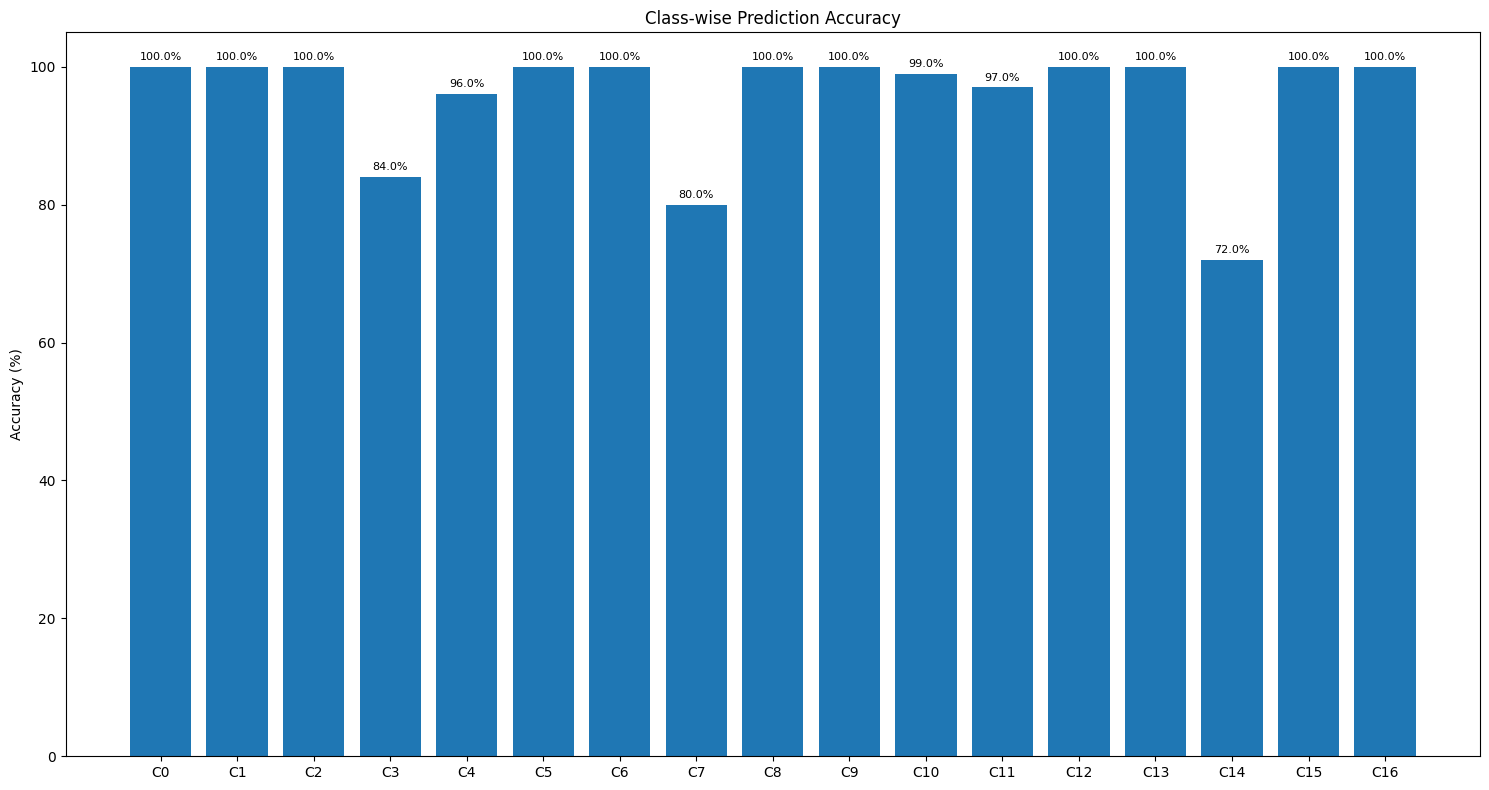

Worst 3 classes:
Class 14: 72.0%
Class 7: 80.0%
Class 3: 84.0%

Mean CV F1: 0.9709 ± 0.0054
Best single fold: 0.9780


In [12]:
# 클래스별 성능 시각화
meta_df = pd.read_csv("../data/meta.csv")
avg_acc = {c: np.mean([f.get(c,0) for f in fold_class_accuracies]) for c in range(17)}

plt.figure(figsize=(15, 8))
classes = list(avg_acc.keys())
accs = [avg_acc[c] * 100 for c in classes]
names = [f"C{c}" for c in classes]

plt.bar(range(17), accs)
plt.xticks(range(17), names)
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Prediction Accuracy')
for i, acc in enumerate(accs):
    plt.text(i, acc + 1, f'{acc:.1f}%', ha='center', fontsize=8)
plt.tight_layout()
plt.show()

print("Worst 3 classes:")
worst = sorted(avg_acc.items(), key=lambda x: x[1])[:3]
for c, acc in worst:
    print(f"Class {c}: {acc*100:.1f}%")
    
print(f"\nMean CV F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Best single fold: {max(val_f1_scores):.4f}")

In [13]:
# 디렉토리 생성
os.makedirs('models', exist_ok=True)

# fold_models 저장 (현재 메모리에 있다면 바로 실행 가능)
print("Saving fold models...")
for i, state_dict in enumerate(fold_models):
    save_path = f'models/fold_{i+1}_best.pth'
    torch.save(state_dict, save_path)  # 그냥 직접 저장
    print(f"✓ Fold {i+1} model saved to {save_path}")

print(f"All {len(fold_models)} fold models saved!")

Saving fold models...
✓ Fold 1 model saved to models/fold_1_best.pth
✓ Fold 2 model saved to models/fold_2_best.pth
✓ Fold 3 model saved to models/fold_3_best.pth
✓ Fold 4 model saved to models/fold_4_best.pth
✓ Fold 5 model saved to models/fold_5_best.pth
All 5 fold models saved!


In [14]:
# 5-Fold 앙상블 모델 준비
ensemble_models = []
for i, state_dict in enumerate(fold_models):
    fold_model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
    fold_model.load_state_dict(state_dict)
    fold_model.eval()
    ensemble_models.append(fold_model)
print(f"Using ensemble of all {len(ensemble_models)} fold models for inference")

Using ensemble of all 5 fold models for inference


## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [15]:
# Temperature Scaling 클래스 정의
class TemperatureScaling(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
    
    def forward(self, logits):
        return logits / self.temperature

In [16]:
essential_tta_transforms = [
    # 원본
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 90도 회전들
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[90, 90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[180, 180], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[-90, -90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 밝기 개선
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.RandomBrightnessContrast(brightness_limit=[0.3, 0.3], contrast_limit=[0.3, 0.3], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
]

In [17]:
# TTA 추론을 위한 Dataset 클래스
class TTAImageDataset(Dataset):
    def __init__(self, data, path, transforms):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.transforms = transforms  # 여러 transform을 리스트로 받음

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert('RGB'))
        
        # 모든 transform을 적용한 결과를 리스트로 반환
        augmented_images = []
        for transform in self.transforms:
            aug_img = transform(image=img)['image']
            augmented_images.append(aug_img)
        
        return augmented_images, target

In [18]:
# TTA Dataset 생성
tta_dataset = TTAImageDataset(
    "../data/sample_submission.csv",
    "../data/test/",
    essential_tta_transforms
)

# TTA DataLoader (배치 크기를 줄여서 메모리 절약)
tta_loader = DataLoader(
    tta_dataset,
    batch_size=64,  # TTA는 메모리를 많이 사용하므로 배치 크기 줄임
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"TTA Dataset size: {len(tta_dataset)}")

TTA Dataset size: 3140


In [19]:
def ensemble_tta_inference(models, loader, transforms, confidence_threshold=0.9):
    """5-Fold 모델 앙상블 + TTA 추론"""
    all_predictions = []
    
    for batch_idx, (images_list, _) in enumerate(tqdm(loader, desc="Ensemble TTA")):
        batch_size = images_list[0].size(0)
        ensemble_probs = torch.zeros(batch_size, 17).to(device)
        
        # 각 fold 모델별 예측
        for model in models:
            with torch.no_grad():
                # 각 TTA 변형별 예측
                for images in images_list:
                    images = images.to(device)
                    preds = model(images)
                    probs = torch.softmax(preds, dim=1)
                    ensemble_probs += probs / (len(models) * len(images_list))
        
        final_preds = torch.argmax(ensemble_probs, dim=1)
        all_predictions.extend(final_preds.cpu().numpy())
    
    return all_predictions

In [20]:
# 앙상블 TTA 실행
print("Starting Ensemble TTA inference...")
tta_predictions = ensemble_tta_inference(
    models=ensemble_models, 
    loader=tta_loader, 
    transforms=essential_tta_transforms,
    confidence_threshold=0.9
)

Starting Ensemble TTA inference...


Ensemble TTA:   0%|          | 0/50 [00:00<?, ?it/s]

Ensemble TTA: 100%|██████████| 50/50 [12:43<00:00, 15.28s/it]


In [21]:
# TTA 결과로 submission 파일 생성
tta_pred_df = pd.DataFrame(tta_dataset.df, columns=['ID', 'target'])
tta_pred_df['target'] = tta_predictions

In [22]:
# 기존 submission과 동일한 순서인지 확인
sample_submission_df = pd.read_csv("../data/sample_submission.csv")
assert (sample_submission_df['ID'] == tta_pred_df['ID']).all()

In [23]:
# TTA 결과 저장
tta_pred_df.to_csv("../submission/choice.csv", index=False)
print("TTA predictions saved")

print("TTA Prediction sample:")

TTA predictions saved
TTA Prediction sample:


In [24]:
tta_pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,12
4,00901f504008d884.jpg,2
